## 모듈 Import

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
from scipy import interpolate
import warnings
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
warnings.filterwarnings("ignore")
sys.path.append(str(Path(os.getcwd())))

## Path 설정

In [2]:
base_path = Path(os.getcwd()).parent
sys.path.append(base_path)

## 폰트 설정

In [3]:
plt.rc('font', family = 'Malgun Gothic')

## 데이터 로딩

In [4]:
water_lst = glob(f'{base_path}/raw_data/water_data/*.csv')
rain_lst = glob(f'{base_path}/raw_data/rf_data/*.csv')

## 데이터 병합

In [5]:
water_lst = glob(f'{base_path}/raw_data/water_data/*.csv')
rain_lst = glob(f'{base_path}/raw_data/rf_data/*.csv')

water_df = pd.DataFrame()
rain_df = pd.DataFrame()
for w in water_lst:
    water_df = water_df.append(pd.read_csv(w))
for r in rain_lst:
    rain_df = rain_df.append(pd.read_csv(r))

## 데이터 명세

In [6]:
# water 데이터 컬럼 설명
"""
ymdhm : 년월일시분
swl : 팔당댐 현재수위 (단위 :El.m)
inf : 팔당댐 유입량 (단위 : m^3/s)
swf : 팔당댐 저수량 (단위 : 만m^3)
ecpc : 팔당댐 공용량 (단위 : 백만m^3)
tototf: 총 방류량 (eksdnl : m^3/s)
tide_level : 강화대교 조위 ( 단위 : cm) # 조위는 조석에 의해 변하는 해수면의 높이
wl_1018662 : 청담대교 수위 ( 단위 : cm)
fw_1018622 : 청담대교 유량 ( 단위 : m^3/s)
(유량은 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타낼 때 쓰는 개념)
wl_1018680 : 잠수교 수위 ( 단위 : cm)
fw_1018680 : 잠수교 유량 ( 단위 : m^3/s)
wl_1018683 : 한강대교 수위 ( 단위 : cm)
fw_1018683 : 한강대교 유량 ( 단위 : m^3/s)
wl_1019630 : 행주대교 수위 ( 단위 : cm)
fw_1019630 : 행주대교 유량 ( 단위 : m^3/s)
"""

# RainFall 데이터 컬럼 설명
"""
YMDHM : 년월일시분
rf_10184100 : 대곡교 강수량(단위 : cm)
rf_10184110 : 진관교 강수량(단위 : cm)
rf_10184140 : 송정동 강수량(단위 : cm)
"""

'\nYMDHM : 년월일시분\nrf_10184100 : 대곡교 강수량(단위 : cm)\nrf_10184110 : 진관교 강수량(단위 : cm)\nrf_10184140 : 송정동 강수량(단위 : cm)\n'

## 데이터 타입 수정

In [7]:
water_df['ymdhm'] = pd.to_datetime(water_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )
rain_df['ymdhm'] = pd.to_datetime(water_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )

In [8]:
merge_df = pd.merge(water_df, rain_df, how = 'left', on = 'ymdhm')

In [9]:
merge_df

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
0,2012-05-01 00:00:00,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18,0.0,0.0,0.0
1,2012-05-01 00:10:00,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18,0.0,0.0,0.0
2,2012-05-01 00:20:00,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18,0.0,0.0,0.0
3,2012-05-01 00:30:00,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17,0.0,0.0,0.0
4,2012-05-01 00:40:00,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10:00,25.040,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,NaN,0.0,-456.41,0.0,974.40,0.0,0.0,0.0
276332,2022-07-18 23:20:00,25.040,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,NaN,0.0,-717.30,0.0,1006.88,0.0,0.0,0.0
276333,2022-07-18 23:30:00,25.040,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,NaN,0.0,-843.37,0.0,1039.90,0.0,0.0,0.0
276334,2022-07-18 23:40:00,25.040,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,NaN,0.0,-1023.37,0.0,1073.46,0.0,0.0,0.0


### 컬럼명 변경

In [10]:
new_cols ={'ymdhm':"date",
           'swl':'팔당댐 현재수위',
           'inf':'팔당댐 유입량',
           'sfw':'팔당댐 저수량',
           'ecpc':'팔당댐 공용량',
           'tototf':'총 방류량',
           'tide_level':"강화대교 조위",
           'fw_1018662':'청담대교 유량',
           'fw_1018680':'잠수교 유량',
           'fw_1018683':'한강대교 유량',
           'fw_1019630':'행주대교 유량',
           'wl_1018662':'청담대교 수위',
           'wl_1018680':'잠수교 수위',
           'wl_1018683':"한강대교 수위",
           'wl_1019630':"행주대교 수위",
           'rf_10184100':'대곡교 강수량',
           'rf_10184110':'진관교 강수량',
           'rf_10184140':'송정동 강수량'}
merge_df =merge_df.rename(columns = new_cols)

### 단위 수정

In [12]:
merge_df['팔당댐 저수량'] = merge_df['팔당댐 저수량'].apply(lambda x: x*10000)
merge_df['팔당댐 공용량'] = merge_df['팔당댐 공용량'].apply(lambda x: x*10000000)


## 데이터셋 분리(train, valid, test)

In [13]:
# test set: 2022 06 01 ~
train = merge_df[-((merge_df['date'].dt.year==2022) & (merge_df['date'].dt.month>=6))].reset_index(drop =True)
test = merge_df[((merge_df['date'].dt.year==2022) & (merge_df['date'].dt.month>=6))].reset_index(drop =True)

In [14]:
test.isna().sum()

date           0
팔당댐 현재수위      36
팔당댐 유입량       36
팔당댐 저수량       36
팔당댐 공용량       36
총 방류량         36
강화대교 조위        4
청담대교 수위        0
청담대교 유량     1216
잠수교 수위         0
잠수교 유량      6912
한강대교 수위        0
한강대교 유량        0
행주대교 수위        0
행주대교 유량        0
대곡교 강수량        0
진관교 강수량        0
송정동 강수량        0
dtype: int64

In [15]:
train.isna().sum()

date             0
팔당댐 현재수위       707
팔당댐 유입량        707
팔당댐 저수량        707
팔당댐 공용량        707
총 방류량          707
강화대교 조위       4923
청담대교 수위         59
청담대교 유량      15164
잠수교 수위          59
잠수교 유량      189937
한강대교 수위         59
한강대교 유량       1279
행주대교 수위         59
행주대교 유량         59
대곡교 강수량          0
진관교 강수량          0
송정동 강수량          0
dtype: int64

- 테스트 데이터의 강화대교와 잠수교의 유량이 결측값으로 존재 이러한 경우 유량이 예측에 중요 변수일경우 예측정확도 감소
- 유량의 결측값을 팔당댐의 방류와 강수량 데이터 그리고 다른 대교들의 유량데이터를 통해 보간할 수 있지않을까?? 
- 팔당댐의 현재수위, 유입량, 저수량, 공용량은 시계열이기때문에 t-n시점의 데이터와 강수량등등으로 유추할 수 있지않을까??(증발고려하기)

## 데이터 보간(Interpolation)

- 팔당댐 보간 -> 팔당댐 데이터로 대교 유량 보간

### 팔당댐 데이터 분석 

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

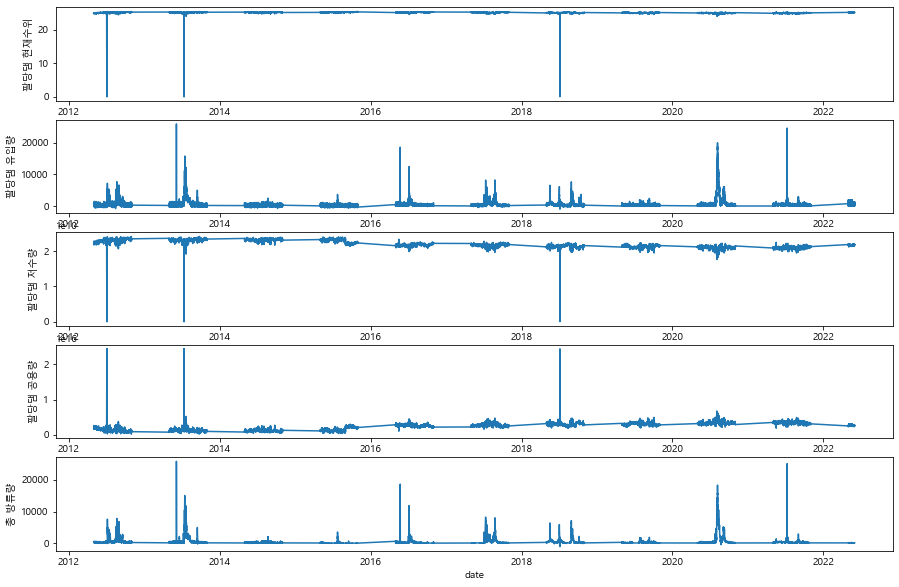

In [16]:
fig,ax = plt.subplots(5,1, figsize = (15,10))
sns.lineplot(train['date'], train['팔당댐 현재수위'], ax = ax[0])
sns.lineplot(train['date'], train['팔당댐 유입량'], ax = ax[1])
sns.lineplot(train['date'], train['팔당댐 저수량'], ax = ax[2])
sns.lineplot(train['date'], train['팔당댐 공용량'], ax = ax[3])
sns.lineplot(train['date'], train['총 방류량'], ax = ax[4])

In [37]:
train[train['팔당댐 현재수위']<=0]

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,강화대교 조위,청담대교 수위,청담대교 유량,잠수교 수위,잠수교 유량,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
9054,2012-07-02 21:00:00,0.0,0.0,0.0,2.440000e+16,0.0,240.0,311.7,476.21,310.2,0.0,299.0,1010.22,284.3,652.89,0.0,0.0,0.0
9060,2012-07-02 22:00:00,0.0,0.0,0.0,2.440000e+16,0.0,176.0,301.7,407.18,299.2,0.0,290.0,326.94,277.3,564.29,0.0,0.0,0.0
9066,2012-07-02 23:00:00,0.0,0.0,0.0,2.440000e+16,0.0,122.0,300.7,400.58,294.2,0.0,283.0,590.88,266.3,438.33,0.0,0.0,0.0
9072,2012-07-03 00:00:00,0.0,0.0,0.0,2.440000e+16,0.0,80.0,295.7,368.42,285.2,0.0,277.0,306.19,268.3,460.03,0.0,0.0,0.0
9078,2012-07-03 01:00:00,0.0,0.0,0.0,2.440000e+16,0.0,158.0,297.7,381.12,286.2,0.0,276.0,184.79,263.3,406.79,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36888,2013-07-12 04:00:00,0.0,0.0,0.0,2.440000e+16,0.0,195.0,405.7,1400.11,379.2,0.0,369.0,2252.24,343.3,1663.48,0.0,0.0,0.0
36894,2013-07-12 05:00:00,0.0,0.0,0.0,2.440000e+16,0.0,290.0,402.7,1362.85,374.2,0.0,365.0,2212.95,340.3,1600.64,0.0,0.0,0.0
36900,2013-07-12 06:00:00,0.0,0.0,0.0,2.440000e+16,0.0,464.0,399.7,1326.12,372.2,0.0,362.0,2144.56,338.3,1559.43,0.0,0.0,0.0
36906,2013-07-12 07:00:00,0.0,0.0,0.0,2.440000e+16,0.0,631.0,396.7,1289.90,370.2,0.0,360.0,2171.14,335.3,1498.64,0.0,0.0,0.0


- 데이터 내에 0인경우와 마이너스인 경우의 이상값이 존재한다.

In [40]:
train[(train['팔당댐 현재수위']<=0) | (train['팔당댐 현재수위'].isna())]

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,강화대교 조위,청담대교 수위,청담대교 유량,잠수교 수위,잠수교 유량,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
9054,2012-07-02 21:00:00,0.0,0.0,0.0,2.440000e+16,0.0,240.0,311.7,476.21,310.2,0.0,299.0,1010.22,284.3,652.89,0.0,0.0,0.0
9060,2012-07-02 22:00:00,0.0,0.0,0.0,2.440000e+16,0.0,176.0,301.7,407.18,299.2,0.0,290.0,326.94,277.3,564.29,0.0,0.0,0.0
9066,2012-07-02 23:00:00,0.0,0.0,0.0,2.440000e+16,0.0,122.0,300.7,400.58,294.2,0.0,283.0,590.88,266.3,438.33,0.0,0.0,0.0
9072,2012-07-03 00:00:00,0.0,0.0,0.0,2.440000e+16,0.0,80.0,295.7,368.42,285.2,0.0,277.0,306.19,268.3,460.03,0.0,0.0,0.0
9078,2012-07-03 01:00:00,0.0,0.0,0.0,2.440000e+16,0.0,158.0,297.7,381.12,286.2,0.0,276.0,184.79,263.3,406.79,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261270,2021-10-06 09:00:00,NaN,NaN,NaN,NaN,NaN,407.0,397.7,1301.92,384.2,NaN,384.0,-448.76,336.3,1518.77,0.0,0.0,0.0
261271,2021-10-06 09:10:00,NaN,NaN,NaN,NaN,NaN,390.0,401.7,1350.55,386.2,NaN,385.0,76.48,333.3,1458.80,0.0,1.0,0.0
262598,2021-10-15 14:20:00,NaN,NaN,NaN,NaN,NaN,NaN,271.7,NaN,264.2,NaN,268.0,297.96,255.3,328.54,0.0,0.0,0.0
262599,2021-10-15 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,271.7,NaN,264.2,NaN,268.0,293.88,256.3,337.86,0.0,0.0,0.0


### 강화대교 조위

<AxesSubplot:xlabel='ymdhm', ylabel='tide_level'>

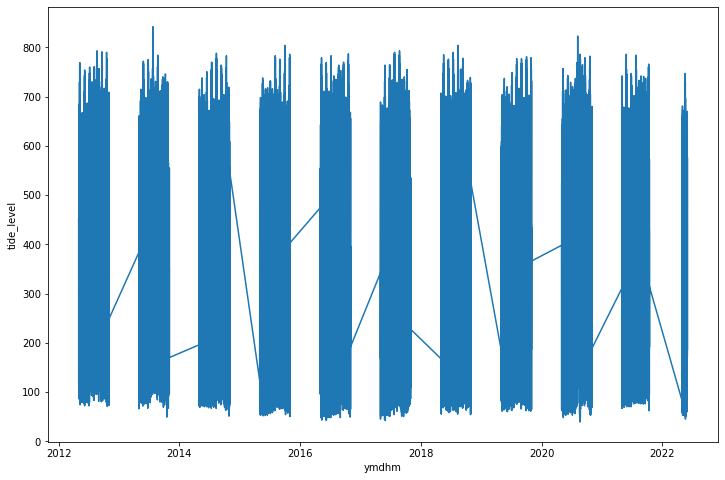

In [22]:
plt.figure(figsize = (12,8))
sns.lineplot(train['ymdhm'], train['tide_level'])

### 대교별 유량

<AxesSubplot:xlabel='ymdhm', ylabel='fw_1019630'>

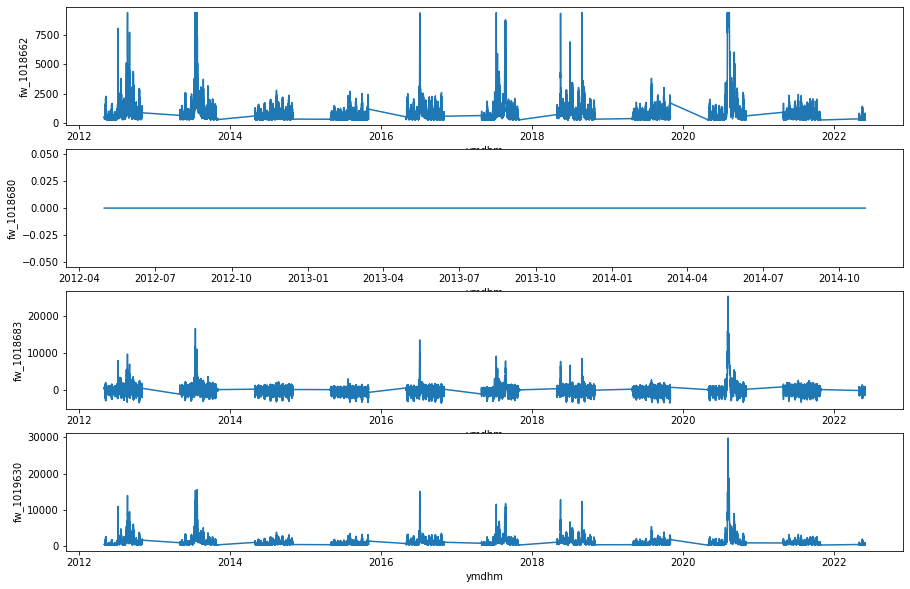

In [30]:
fig,ax = plt.subplots(4,1,figsize=(15,10))
sns.lineplot(train['ymdhm'], train['fw_1018662'],ax = ax[0])
sns.lineplot(train['ymdhm'], train['fw_1018680'],ax = ax[1])
sns.lineplot(train['ymdhm'], train['fw_1018683'],ax = ax[2])
sns.lineplot(train['ymdhm'], train['fw_1019630'],ax = ax[3])